In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import scipy.optimize as sciopt
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')

from f_ring_util.f_ring import (add_hover,
                                read_ew_stats)
import gravity

LONG_RES = 0.02  # deg/pixel
RAD_RES  = 5     # km/pixel
RADIAL_STEP = 5  # km per CSV column

F_PROM_BEAT = 3.2619  # Longitudes between Prometheus/F ring core interactions
F_RING_N = 581.964    # deg/day
F_RING_A = 140221.3   # km
F_RING_E = 0.00235
F_RING_I = 0.00643    # deg
F_RING_SIN_I = np.sin(np.radians(F_RING_I))

# The gravity module's idea of the mean motion of the F ring core isn't precisely the same
# as that found through measurement
F_RING_N_FUDGE = F_RING_N / (np.degrees(gravity.SATURN.n(F_RING_A, F_RING_E, F_RING_SIN_I))*86400)

%matplotlib notebook

In [12]:
def interp_ypts(offset, stretch, ypts, fill=None):
    # Interpolate a profile at a new set of longitudes stretched by "stretch" and offset by "offset".
    
    # The range of longitudes for the original data; we don't care about the 
    # absolute values, only the step size
    old_long = np.arange(len(ypts)) * LONG_RES

    # Find the new longitudes to sample at based on stretch and offset
    # We want to stretch such that the higher longitudes stay in place and the lower
    # longitudes shrink or enlarge
    new_long = (old_long - old_long[-1] - offset) * stretch + old_long[-1]
    
    # Compute the new data using interpolation
    # If we try to interpolate with data we don't have, set it to "fill".
    new_ypts = np.interp(new_long, old_long, ypts, left=fill, right=fill)

    return new_ypts

def fit_func(params, ypts1, ypts0):
    # Helper function for optimization. Given optimization parameters "params" (offset, stretch),
    # compute the interpolated data, remove bad points, and return the RMS.
    
    assert len(ypts1) == len(ypts0)
    
    # offset is specified in degrees
    # stretch is specified as a factor;
    #    1 means leave the original ypts1 alone
    #   >1 means shrink the data to be narrower
    #   <1 means grow the data to be wider
    offset, stretch = params
    
    new_ypts0 = interp_ypts(offset, stretch, ypts0, fill=1e38)
    good_mask = (new_ypts0 != 1e38) & ~np.isnan(new_ypts0) & ~np.isnan(ypts1)
    # If the interpolation made the data set shorter, we don't want to compare
    # useless data
    new_ypts1 = ypts1[good_mask]
    new_ypts0 = new_ypts0[good_mask]
    
    return np.sum((new_ypts1-new_ypts0)**2)

def align_profiles(obsdata, a1, a0, bounds_stretch=None, verbose=True):
    # Given a DataFrame and two semi-major axes (a1>a0), figure out the stretch
    # required to align them. We assert that the offset will be zero.
    
    # Find the mean motion at the two semi-major axes, adjusted for error
    n0 = np.degrees(gravity.SATURN.n(a0, F_RING_E, F_RING_SIN_I)) * F_RING_N_FUDGE
    n1 = np.degrees(gravity.SATURN.n(a1, F_RING_E, F_RING_SIN_I)) * F_RING_N_FUDGE
    # Compute how much a particle moves at a0 during one orbit at a1 and derive the slope in
    # deg/km
    t1 = 360/n1 # Time for one orbit at a1
    deg0 = t1*n0 # Longitude distance at a0 during time of one orbit at a1
    expected_slope = (deg0-360)/(a1-a0) # deg/km

    # Give a wiggle room for the slope
    expected_slope_min = expected_slope * 0.7
    expected_slope_max = expected_slope * 1.3
    if verbose:
        print('Expected slope',     expected_slope)
        print('Expected slope min', expected_slope_min)
        print('Expected slope max', expected_slope_max)

    # Compute the stretch from the slope
    expected_stretch     = 1 - expected_slope     * (a1-a0) / F_PROM_BEAT
    expected_stretch_max = 1 - expected_slope_min * (a1-a0) / F_PROM_BEAT
    expected_stretch_min = 1 - expected_slope_max * (a1-a0) / F_PROM_BEAT
    if verbose:
        print('Expected stretch',     expected_stretch)
        print('Expected stretch min', expected_stretch_min)
        print('Expected stretch max', expected_stretch_max)
    
    if bounds_stretch is None:
        bounds_stretch = (expected_stretch_min, expected_stretch_max)
        
    ypts1 = obsdata[f'Normal EW{a1} Mean'].to_numpy()
    ypts0 = obsdata[f'Normal EW{a0} Mean'].to_numpy()

    # Apply a small median filter to reduce the noise in the profiles
    norm_ypts1 = ndimage.median_filter(ypts1, size=5, mode='nearest')
    norm_ypts0 = ndimage.median_filter(ypts0, size=5, mode='nearest')
    
    norm_ypts1 = norm_ypts1 / np.mean(ypts1)
    norm_ypts0 = norm_ypts0 / np.mean(ypts0)
    
    ypts1 = norm_ypts1
    ypts0 = norm_ypts0
    
    best_stretch = None
    best_resid = 1e38
    for trial_stretch in np.arange(expected_stretch_min, expected_stretch_max+1e-10, 0.0001):
        resid = fit_func((0, trial_stretch), norm_ypts1, norm_ypts0)
        if resid < best_resid:
            best_resid = resid
            best_stretch = trial_stretch
    fail = (best_stretch == expected_stretch_min) or (best_stretch == expected_stretch_max)
    stretch = best_stretch
    offset = 0
    new_ypts0 = interp_ypts(0, stretch, ypts0)
    
    # Reverse compute the slope from the stretch
    slope = (1-stretch)*F_PROM_BEAT / (a1-a0)
    slope_ratio = slope / expected_slope

    if verbose:
        print('Offset', offset)
        print('Stretch', stretch)
        print('Slope', slope)
        print('Slope ratio', slope_ratio)

    metadata = {
        'fail': fail,
        'expected_slope': expected_slope,
        'expected_stretch': expected_stretch,
        'stretch': stretch,
        'slope': slope,
        'slope_ratio': slope_ratio,
        'ypts1': ypts1,
        'ypts0': ypts0,
        'new_ypts0': new_ypts0
    }
    return metadata

def plot_channels(obsdata, metadata):
    ypts1 = metadata['ypts1']
    ypts0 = metadata['ypts0']
    new_ypts0 = metadata['new_ypts0']
    longitudes = obsdata['Min Long']
    plt.figure()
    plt.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color='blue', label='Primary')
    plt.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='orange', label='Secondary Orig')
    plt.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=1, color='red', label='Secondary Opt')
    plt.legend()
    plt.show()

In [13]:
def make_mega_plot(max_a, min_a, obs_name, delta_a=5):
    plt.figure()
    fix, axs = plt.subplots(int(np.ceil((max_a-min_a)/delta_a/3)), 3, figsize=(15,(max_a-min_a)/delta_a/2))
    slope_ratios = []
    offsets = []
    rs = []
    plt_num = 0
    colors = ['blue', 'red']

    #fix.tight_layout()
    fix.subplots_adjust(wspace =.05, hspace = .3)
    fix.suptitle(obs_name, y=.89)

    for r in range(max_a, min_a-1, -delta_a):
    #     metadata = align_profiles(obsdata, r, r-5, verbose=False)
        metadata = align_profiles(obsdata, r, r-delta_a, verbose=False)
        if (not metadata['fail']):
            rs.append(r)
            slope_ratios.append(metadata['slope_ratio'])
        ax = axs[int(plt_num/3), plt_num%3]
        ypts1 = metadata['ypts1']
        ypts0 = metadata['ypts0']
        new_ypts0 = metadata['new_ypts0']
        longitudes = obsdata['Min Long']

        slope_ratio = metadata['slope_ratio']
        slope = metadata['slope']

        if (metadata['fail']):
            colors = ['green', 'orange']
    
        ax.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color=colors[0])
#     ax.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='green')
        ax.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=2, color=colors[1])
        ax.set_yticks([])
        label_text = f'Slope Ratio = {slope_ratio:.6f}  Range = {r-delta_a:d}-{r:d}'
        ax.set_xlabel(label_text, size = 8)
        if (plt_num < ((max_a-min_a)/delta_a)-2):
            ax.set_xticks([])
        colors = ['blue', 'red']
        plt_num += 1
    
    return rs, slope_ratios

In [14]:
obsdata = read_ew_stats('../data_files/ISS_092RF_FMOVIE003_PRIME-cs.csv')
# obsdata = read_ew_stats('../data_files/ISS_039RF_FMOVIE001_VIMS-cs.csv')
# metadata = align_profiles(obsdata, 140400, 140300, bounds_offset=(-0.001, 0.001)) # 140400/139360
# rs, slope_ratios = make_mega_plot(140140,139910,'ISS_092RF_FMOVIE003_PRIME',delta_a=20)
# make_mega_plot(139920,139915,'ISS_092RF_FMOVIE003_PRIME')



** SUMMARY STATISTICS - ../data_files/ISS_092RF_FMOVIE003_PRIME-cs.csv **
Unique observation names: 1
Total slices: 747
Starting date: 2008-11-07 03:29:03
Ending date: 2008-11-07 04:04:47
Time span: 0 days 00:35:44


In [15]:
# plt.plot(rs, slope_ratios)

Expected slope 0.0038714773806418634
Expected slope min 0.002710034166449304
Expected slope max 0.005032920594834423
Expected stretch 0.9940656099502715
Expected stretch min 0.992285292935353
Expected stretch max 0.99584592696519
Offset 0
Stretch 0.992285292935353
Slope 0.005032920594834444
Slope ratio 1.3000000000000054


<IPython.core.display.Javascript object>


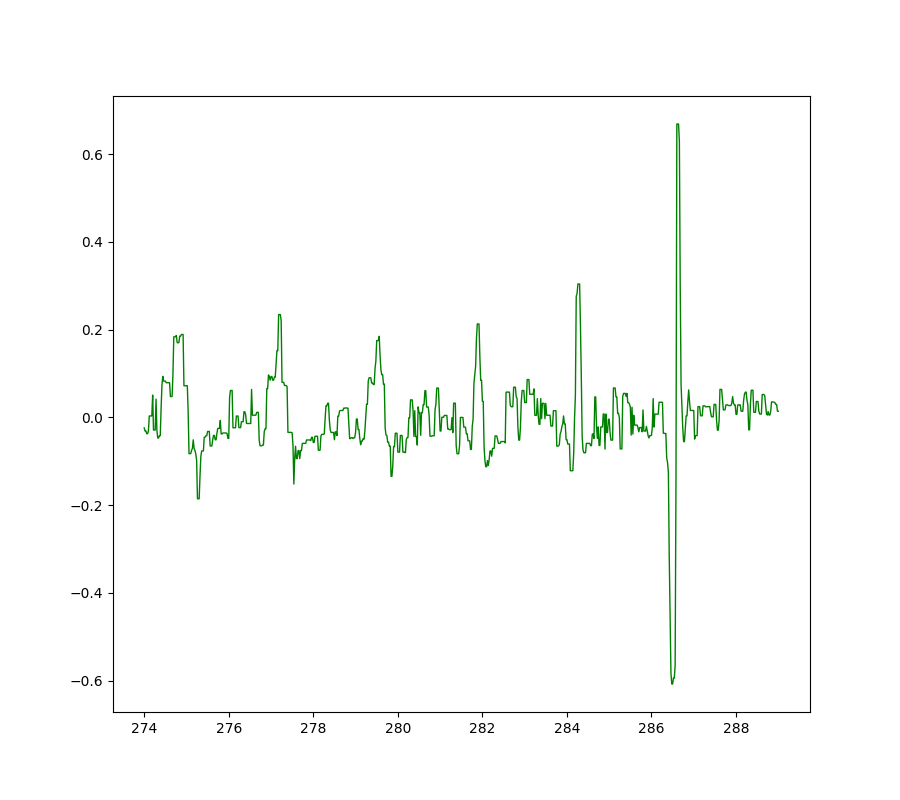

In [19]:
# metadata = align_profiles(obsdata, 140285, 140280)
metadata = align_profiles(obsdata, 139920, 139915)
ypts1 = metadata['ypts1']
ypts0 = metadata['ypts0']
new_ypts0 = metadata['new_ypts0']
longitudes = obsdata['Min Long']
plt.figure(figsize=(9,8))
plt.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color='red')
# plt.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=2, color='blue')
plt.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='green')